*** Méthodes Numériques: Module 3 ***

# Sod' s Shock tube par la méthode de Richtmyer  #

## 1. Introduction:
Dans ce module, nous allons résoudre le problème du "Shock tube". Il s'agit d'un problème intéressant car il possède une solution analytique et permet donc d'évaluer l'efficacité d'une méthode numérique. Nous allons utiliser la méthode de Richtmyer qui sera décrite plus loin. Comme d'habitude, nous importons numpy, sympy, matplotlib et également les outils pour créer des animations matplotlib.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16

from matplotlib import animation
from IPython.display import HTML

import sympy
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

## 2. Principe: ###
Le shock tube est un tube à une dimension rempli de gaz et comportant deux compartiments avec des pressions différentes. Au temps t=0.0s, on enlève la membrane qui sépare les deux compartiments.
La différence de pression va créer une onde de choc de la zone de haute pression vers la zone de basse pression en même temps qu'une onde d'expansion dans l'autre sens. 
Pour modéliser ce système, on utilise les équations de conservation de la masse, de l'impulsion et de l'énergie => les équations d'Euler:
\begin{cases}
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho v) &= 0 \\
\frac{\partial}{\partial t}(\rho v) + \frac{\partial}{\partial x} (\rho v^2 + p)&=0\\
\frac{\partial}{\partial t}(\rho e_T) + \frac{\partial}{\partial x} (\rho u e_T +p u)&=0
\end{cases}
où v est la vitesse en direction x, $\rho$ est la densité, p est la pression du fluide et $e_T=e+u^2/2$ est l'énergie totale.


**Nb**: Nous appelons la vitesse v plutôt que u (notation utilisée dans l'énoncé) pour éviter la confusion avec le vecteur u qui sera introduit plus loin.

On voit que si on pose 
\begin{equation}\underline{\mathbf{u}} = \left[ \begin{array}{c}
\rho \\
\rho v \\
\rho e_T \\ 
\end{array} \right]\end{equation}
et
\begin{equation}\underline{\mathbf{f}} = \left[ \begin{array}{c}
\rho v \\
\rho v^2 + p \\
(\rho e_T + p) v \\ \end{array} \right]
\end{equation}
alors notre système de trois équations se réécrit simplement: 
\begin{equation}
\frac{\partial }{\partial t} \underline{\mathbf{u}} + \frac{\partial }{\partial x} \underline{\mathbf{f}} = 0
\end{equation}
qui est l'équation que nous allons résoudre.

## 3. Fonctions:

Nous créons une fonction u qui a pour arguments la densité, la vitesse et la pression et qui renvoie le vecteur u comme défini ci-dessus.

In [2]:
def vector_u(rho,v,p):
    u=numpy.array([rho,rho*v,rho*(p/(0.4*rho)+0.5*(v)**2)])
    return u

Ensuite nous créons une fonction qui prend le vecteur u qu'on vient de calculer et qui calcule le f correspondant, en effet on peut exprimer f comme une fonction de u comme ceci:
$$\underline{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$
Et il sera très pratique d'avoir cette fonction sous la main pour appliquer la méthode de Richtmyer.


_**Démontrons cette égalité:**_

L'équation d'état d'un gaz parfait peut s'écrire comme: $$e=\frac{p}{(\gamma-1)*\rho}$$ où $\gamma=\frac{C_{p}}{C_{V}}$ est le rapport des capacités massiques à pression et à volume constants. Nous le prendrons égal à 1,4 ( ce qui est la valeur théorique pour un gaz diatomique). 

Comme $e_{T}=e+\frac{v²}{2}$, on obtient que $$p=(\gamma-1)\rho*(e_{T}-\frac{v^2}{2})$$ et en remplaçant cette valeur dans l'expression pour f, nous pouvons ensuite l'exprimer en fonction des composantes de u.

In [3]:
def computef(u):
    # on définit f comme fonction de u, donné par la formule précédente
    f=numpy.zeros_like((u))
    f[0]=u[1]
    f[1]=u[1]**2/u[0]+0.4*(u[2]-0.5*u[1]**2/u[0])
    f[2]=(u[1]/u[0])*(u[2]+0.4*(u[2]-0.5*u[1]**2/u[0]))
    return f

## 4. Résolution par la méthode de Richtmyer:

Nous allons à présent résoudre notre équation en utilisant la méthode de Richtmyer. Celle-ci utilise un pas intermédiaire pour calculer l'étape suivante. Cette méthode, contrairement à celle de discrétisation en avant dans le temps et en arrière dans l'espace ( que nous avons utilisée dans le Module 2), reste valable lorsqu'on a des ondes se propageant dans les deux sens selon x, ce qui est le cas ici.

\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}

Nous définissons la fonction Shock qui prend un vecteur initial u0 de la forme du u décrit plus haut et qui calcule l'évolution de u0 après un temps t=nt*dt par la méthode de Richtmyer. dx est le pas spatial.

In [4]:
def Shock(u0,nt,dt,dx,nx):
    uu=u0.copy()#on fait une copie pour ne pas changer la valeur de u0
    medium=numpy.zeros((3,nx-1))
    for t in range(nt):
        vv=uu.copy()#on conserve la valeur de u du temps précédent car nous devrons l'utiliser dans la deuxième étape de/
                    #notre itération
        f=computef(uu)
        
        #Première étape: on crée une liste qui reprend les valeurs intermédiaires u(n+1/2,i+1/2):
        medium[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
        ff=computef(medium)
        
        #Deuxième étape: on calcule à présent le pas suivant en utilisant l'étape intermédiaire:
        vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])
        
        uu=vv.copy()#on remplace uu par sa valeur au temps suivant
        
    return uu

**A présent nous effectuons l'opération inverse du calcul du vecteur u:**

A partir du vecteur u calculé au temps $t=nt*dt$, on calcule une matrice telle que:
- première colonne: vecteur densité du gaz au temps t
- deuxième colonne: vecteur vitesse du gaz au temps t 
- troisième colonne: vecteur pression du gaz au temps t

In [5]:
def plot(u):
    v=numpy.zeros_like(u)
    v[0,:]=u[0,:]
    v[1,:]=u[1,:]/u[0,:]
    v[2,:]=0.4*(u[2,:]-0.5*u[1,:]**2/u[0,:])
    return v

## 5. Application numérique: Réponse aux questions

Nous allons à présent essayer notre méthode sur un cas particulier. 

On commence par choisir dt, L et nx.

In [6]:
L=20 #km (from -10 to +10)
dt=0.0002 #second
nx=81 #so that we cover 20 km, from -10 to +10
dx= L/(nx-1)

In [7]:
x=numpy.linspace(-10,10,nx)

On donne les conditions initiales du gaz sous forme d'une matrice: la première ligne donne la densité à chaque position, la deuxième donne la vitesse à chaque position et le troisième donne la pression à chaque position. On calcule ensuite le vecteur u de ces conditions initiales dans v0.

In [8]:
IC=numpy.zeros((3,nx))
IC[0,:40]=1.0 #kg/m³
IC[0,40:]=0.125 #kg/m³
IC[1,0:]=0.0 #m/s
IC[2,:40]=100000.0 #N/m²
IC[2,40:]=10000.0 #N/m²
v0=vector_u(IC[0],IC[1],IC[2])

In [9]:
t=0.01#s temps final auquel on veut regarder la solution
nt=int(t/dt)#il n'est pas nécessaire de rajouter une étape car la première valeur que l'on calcule est celle après une étape
shock=Shock(v0,nt,dt,dx,nx)

### Simulations results:
_Calculer la densité en kg/m³, la vitesse en m/s et la pression en N/m² au temps **t=0.01s** à la position **x=2.5 m**_

Comme le pas spatial est de 0.25m et que l'élément 0 de la matrice se trouve en  -10 mètres, pour arriver en x=2.5m il nous faudra:

In [10]:
Dx=(2.5-(-10.0))/0.25
print(Dx,'étapes')

50.0 étapes


In [11]:
print('La densité au temps t=0.01s à la position x=2.5m est de',round(plot(shock)[0,50],2),'kg/m³')
print('La vitesse au temps t=0.01s à la position x=2.5m est de',round(plot(shock)[1,50],2),'m/s')
print('La pression au temps t=0.01s à la position x=2.5m est de',round(plot(shock)[2,50],2),'N/m²')

La densité au temps t=0.01s à la position x=2.5m est de 0.37 kg/m³
La vitesse au temps t=0.01s à la position x=2.5m est de 292.61 m/s
La pression au temps t=0.01s à la position x=2.5m est de 30250.89 N/m²


Et ce sont bien les valeurs que nous voulions obtenir, ce qui confirme que notre code fonctionne correctement.

## 6. Interprètation
Nous allons nous intéresser au résultat physique fourni par la méthode de Richtmyer et le comparer à la solution analytique. Nous regarderons également l'évolution temporelle et puis nous nous intéresserons à une amélioration de la méthode ainsi qu'à d'autres conditions initiales.

### Graphiques:
Nous commencons par créer des fonctions qui dessinerons les graphiques de la densité, vitesse et pression en fonction de la position au temps t=0.01s

In [12]:
def graphdensity(vector):
    pyplot.plot(x,vector[0], color='blue', lw=1.1)
    pyplot.ylim(0.0,1.1);
    pyplot.xlabel('x (km)', fontsize=14) #x label
    pyplot.ylabel('rho (kg/m³)', fontsize=14) #y label,
    pyplot.title('Densité en fonction de la position', y=1.08, fontsize=15) ;

In [13]:
def graphvelo(vector):
    pyplot.plot(x,vector[1], color='red', lw=1.1)
    pyplot.ylim(0.0,450.0);
    pyplot.xlabel('x (km)', fontsize=14) #x label
    pyplot.ylabel('v (m/s)', fontsize=14) #y label,
    pyplot.title('Vitesse en fonction de la position', y=1.08, fontsize=15) ;

In [14]:
def graphpress(vector):
    pyplot.plot(x,vector[2],color='magenta',lw=1.1)
    pyplot.ylim(0.0,120000.0);
    pyplot.xlabel('x (km)', fontsize=14) #x label
    pyplot.ylabel('p (N/m²)', fontsize=14) #y label,
    pyplot.title('Pression en fonction de la position', y=1.08, fontsize=15) ;

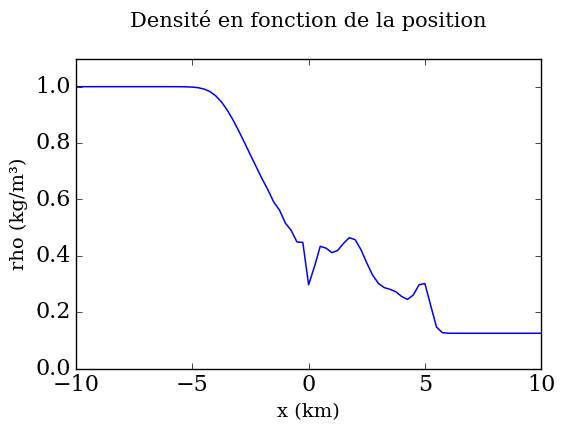

In [15]:
graphdensity(plot(shock))

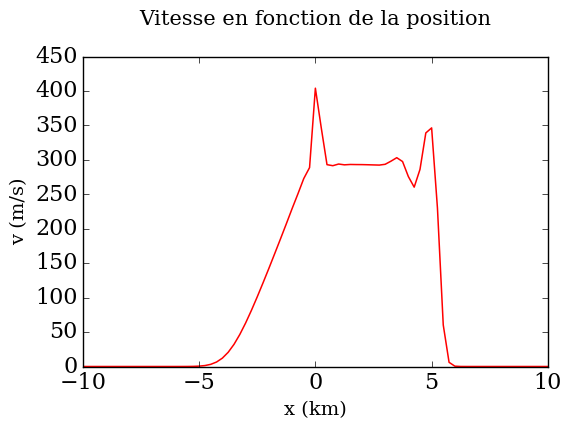

In [16]:
graphvelo(plot(shock))

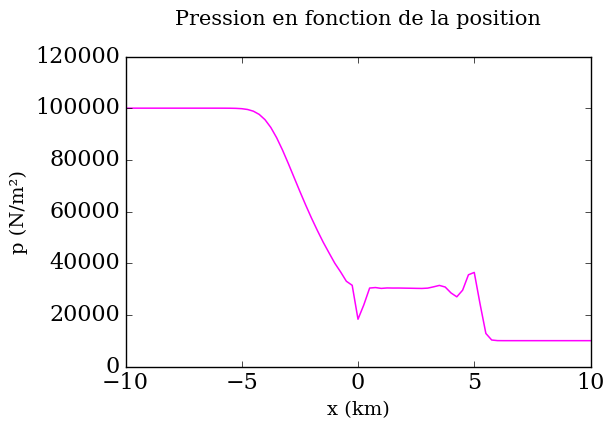

In [17]:
graphpress(plot(shock))

La forme générale des graphiques ressemble fortement à celle de la solution analytique donnée dans le notebook, mis à part la présence de pics aux zones de changements de paliers. Ces pics sont dûs à la discrétisation de la méthode de Richtmyer et cela nous apprend que cette méthode n'est pas optimale et pourrait être améliorée. Nous y reviendrons un peu plus loin.

### Evolution dans le temps:
Pour visualiser l'évolution dans le temps de la densité de gaz dans me tube, nous allons faire une animation. Nous réecrivons notre fonction Shock à l'intérieur de la fonction anim(i) qui va calculer la valeur de la densité à chaque instant et en faire une animation. Comme on regarde la densité, on peut directement prendre la valeur u[0] sans passer par la fonction plot.

In [18]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(-10,10), ylim=(0.0,1.1))
line = ax.plot([], [], color='cyan', lw=2)[0]
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (voitures/km)', fontsize=14) #y label
pyplot.title('Densité du gaz en fonction de la position', y=1.08)
pyplot.close()

In [19]:
u=numpy.zeros((3,81))
un=numpy.zeros((3,81))
nt=50

In [20]:
uu=v0.copy()#on fait une copie pour ne pas changer la valeur de u0
medium=numpy.zeros((3,nx-1))
def density(i):
    global uu
    vv=uu.copy()#on conserve la valeur de u du temps précédent car nous devrons l'utiliser dans la deuxième étape de/
                    #notre itération
    f=computef(uu)
        
    #Première étape: on crée une liste qui reprend les valeurs intermédiaires u(n+1/2,i+1/2):
    medium[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
    ff=computef(medium)
        
    #Deuxième étape: on calcule à présent le pas suivant en utilisant l'étape intermédiaire:
    vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])
        
    uu=vv.copy()#on remplace uu par sa valeur au temps suivant
    line.set_data(x,uu[0])
    

In [21]:
anim = animation.FuncAnimation(fig, density,frames=nt, interval=200)

In [22]:
HTML(anim.to_html5_video())

On voit que les pics apparaissent dès le début de la discrétisation. Ils sont donc inhérents à la méthode et ne correspondent pas à un comportement physique mais à des défauts de la méthode. Nous allons à présent voir si en peut s'en passer.

### Lissage de la courbe et terme d'amortissement

Après quelques recherches, nous trouvons l'existence d'une manière simple de "lisser" les graphes obtenus pour les rendre plus proches de la solution idéale par l'introduction d'un terme supplémentaire dans les formules de Richtmyer. Par défaut, ce terme est nul dans la solution de base, mais on peut le rendre supérieur à zéro de manière à ajuster la courbe pour la rendre plus conforme à la solution réelle sans modifier la méthode utilisée.

Voici le terme d'amortissement : 
$\epsilon (\underline{\mathbf{u}}^{n}_{i+1} - 2\underline{\mathbf{u}}^{n}_{i} + \underline{\mathbf{u}}^{n}_{i-1})$
, où $\epsilon$ est le coefficient d'amortissement, nul par défaut et gardé positif sinon.

Ce terme apparait dans la seconde équation de la méthode, comme ceci :
$\underline{\mathbf{u}}^{n+1}_i = \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right) + \epsilon (\underline{\mathbf{u}}^{n}_{i+1} - 2\underline{\mathbf{u}}^{n}_{i} + \underline{\mathbf{u}}^{n}_{i-1})$

(voir : http://nbviewer.jupyter.org/github/barbagroup/PASI2013/blob/master/lessons/02_Sod.Shock.Tube.ipynb ,dans la partie 
##### "Richtmyer method - damping")

- Créons une fonction appelée "Smooth", identique à la fonction "Shock", à l'exception de l'ajout d'un argument appelé "damp" correspondant au coefficient $\epsilon$, et du terme d'amortissement. L'utilisation de cette fonction, avec des valeurs de "damp" supérieures à zéro, nous permettra de lisser les courbes que nous avions obtenues plus tôt et de voir si elles correspondent bien à une approche de la solution analytique de Sod.

In [23]:
def Smooth(v0,nt,damp): #ajout de l'argument 'damp'.
    uu=v0.copy()
    medium=numpy.zeros((3,80))
    for t in range(nt):
        
        vv=uu.copy()
        f=computef(uu)
        medium[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
        ff=computef(medium)
        vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])+0.1* \
        + damp * (uu[:,2:] - 2*uu[:,1:-1] + uu[:,:-2]) #ajout du terme d'amortissement.
        
        uu=vv.copy()
        
    return uu

- Essayons avec un coefficient d'amortissement $\epsilon$ = 0.4 :

In [24]:
smooth = Smooth(v0,50,0.4)

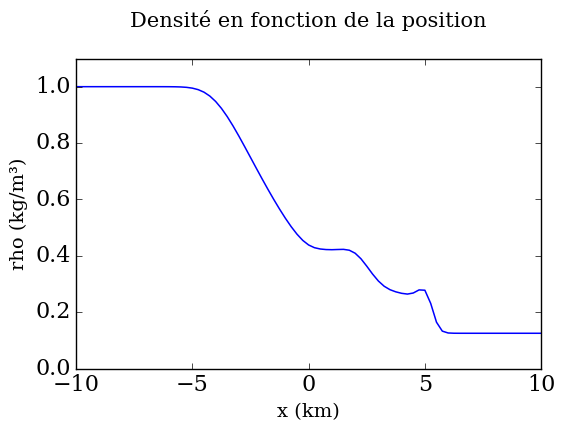

In [25]:
graphdensity(plot(smooth))

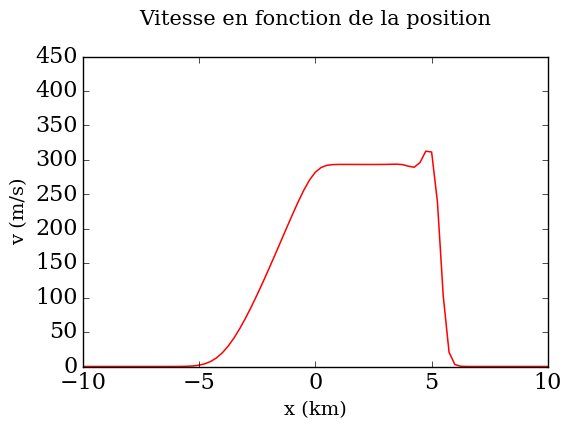

In [26]:
graphvelo(plot(smooth))

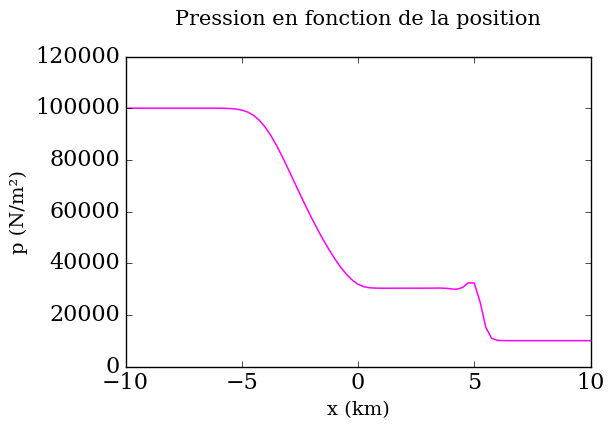

In [27]:
graphpress(plot(smooth))

On remarque qu'on a gardé pour chaque variable (densité, vitesse, pression), une allure de graphique similaire à celle qu'on avait sans amortissement, mais que les pics gênants ont presque déserté les courbes.

Si on observe les courbes données dans la leçon reprenant les solutions graphiques analytiques, nous voyons que l'allure de nos courbes lissées correspond de manière satisfaisante au comportement attendu. 

### Evolution dans le temps de la courbe amortie

In [28]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(-10,10), ylim=(0.0,1.1))
line = ax.plot([], [], color='cyan', lw=2)[0]
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (voitures/km)', fontsize=14) #y label
pyplot.title('Densité du gaz en fonction de la position', y=1.08)
pyplot.close()

In [29]:
uu=numpy.array((3,nx))
uu=v0.copy()
nt=50
medium=numpy.zeros((3,nx-1))

In [30]:
def density2(i):
    global uu
    damp=0.4    
    vv=uu.copy()
    f=computef(uu)
    medium[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
    ff=computef(medium)
    vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])+0.1* \
    + damp * (uu[:,2:] - 2*uu[:,1:-1] + uu[:,:-2]) #ajout du terme d'amortissement.
        
    uu=vv.copy()
    line.set_data(x,uu[0])

In [31]:
anim2 = animation.FuncAnimation(fig, density2,frames=nt, interval=100)

In [32]:
HTML(anim2.to_html5_video())

### D'autres conditions initiales

Nous pouvons utiliser la méthode de Richtmyer pour examiner une évolution dans une situation initiale différente.
Ici , nous prenons un tube de même longueur avec un gaz d'une densité et à une pression données séparé par deux parois d'épaisseur négligeable de deux compartiments à l'une et l'autre extrémité du tube contenant un gaz (identique dans les deux compartiments) d'une densité et à une pression supérieures.

Nous observerons l'évolution de la pression et de la densité dans le tube au cours du temps, pour un temps zéro correspondant à la suppression simultanée des parois.

- Posons ces nouvelles conditions initiales NIC pour le problème :

In [33]:
NIC=numpy.zeros((3,nx))
NIC[0,:21]=1.0 #kg/m³
NIC[0,21:60]=0.125 #kg/m³
NIC[0,60:]=1.0 #kg/m³
NIC[1,0:]=0.0 #m/s
NIC[2,:21]=100000.0 #N/m²
NIC[2,21:60]=10000.0 #N/m²
NIC[2,60:]=100000.0 #N/m²

- La vitesse est nulle partout au temps t=0s. 
- Voyons à quoi ressemble la situation dans le tube à ce moment au niveau de la pression et de la densité :

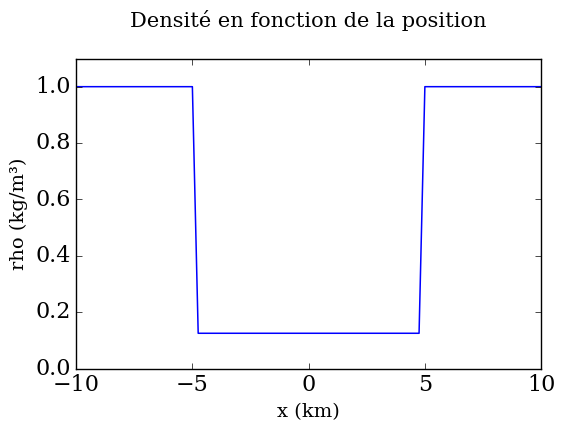

In [34]:
graphdensity(NIC)

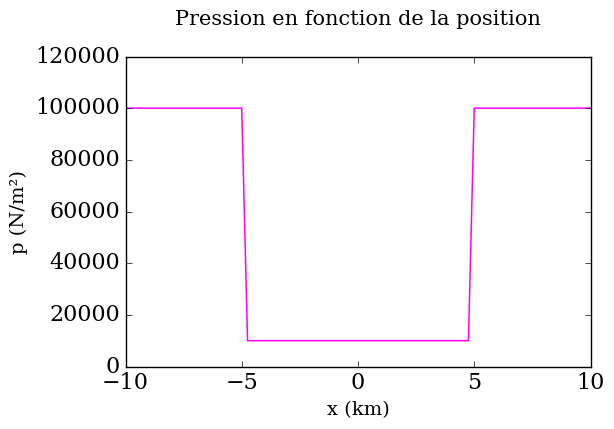

In [35]:
graphpress(NIC)

Nous appliquerons simplement la méthode de Richtmyer (avec amortissement) à nos nouvelles conditions initiales.

**Attention !** 
Nous devons avant tout imposer que le gaz du compartiment de droite ait une vitesse négative (se dirige vers la gauche).
À des temps assez petits pour que le gaz du compartiment de droite n'ait pas encore atteint le centre du tube, nous pouvons simplement poser la condition que la vitesse est négative dans la partie droite du tube en modifiant la fonction "ans":

In [36]:
def newplot(vector):
    v=numpy.ones((3,nx))
    v[0,:]=vector[0,:]
    for j in range (nx):
    #On impose la condition mentionnée plus haut :
        if j>(nx-1)/2 :
            v[1,j]=-(vector[1,j]/vector[0,j])
        else :
            v[1,j]=vector[1,j]/vector[0,j]

        v[2,j]=0.4*(vector[2,j]-0.5*vector[1,j]**2/vector[0,j])
    return v

- Nous regardons ce qu'il se passe à un temps petit. Voyons la situation à t=0,004s (après 20 pas de temps) :

In [37]:
v00=vector_u(NIC[0],NIC[1],NIC[2])
smooth2 = Smooth(v00,20,0.4)

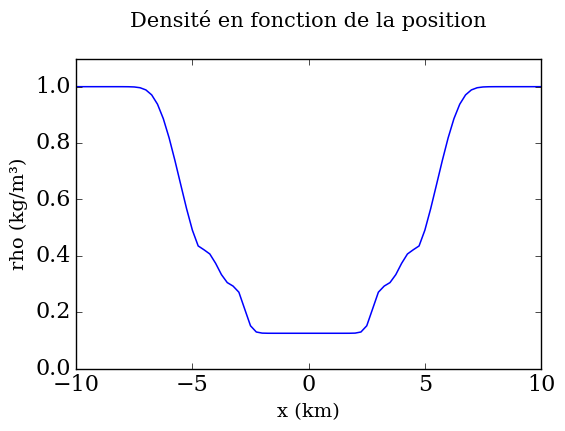

In [38]:
graphdensity(newplot(smooth2))

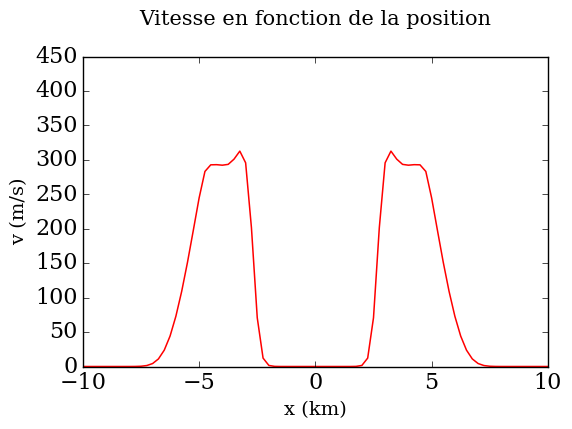

In [39]:
graphvelo(newplot(smooth2))

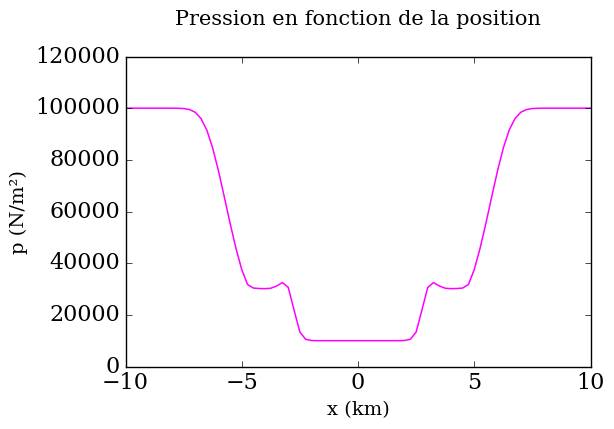

In [40]:
graphpress(newplot(smooth2))

On a bien maintenant un comportement similaire des gaz à celui de la première situation, mais avec le gaz de plus haute densité se déplaçant de concert de part et d'autre du centre du tube vers la zone de gaz de plus faible densité.

- Regardons ce qu'on a après 0.01s (soit après 50 pas de temps) 

In [41]:
smooth3 = Smooth(v00,50,0.4)

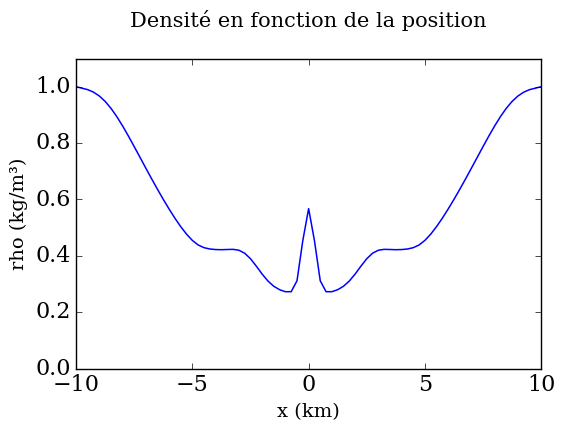

In [42]:
graphdensity(newplot(smooth3))

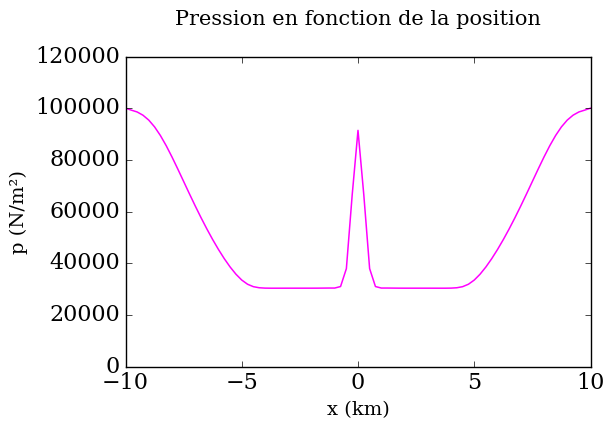

In [43]:
graphpress(newplot(smooth3))

Les ondes correspondant à la densité et la pression ont commencé à interférer dès qu'elles ont atteint leur point de croisement (à peu près au centre du tube).

$\underline{Note}$ : nous ne pouvons plus aisément gérer la vélocité après un temps suffisamment grand pour que les gaz venant de la gauche et de la droite aient atteint leur point de rencontre. Voilà pourquoi nous nous intéressons ici uniquement à la pression et à la densité.

- Nous pouvons prolonger. Ici, en étendant à 70 pas de temps :

In [44]:
smooth4 = Smooth(v00,70,0.4)

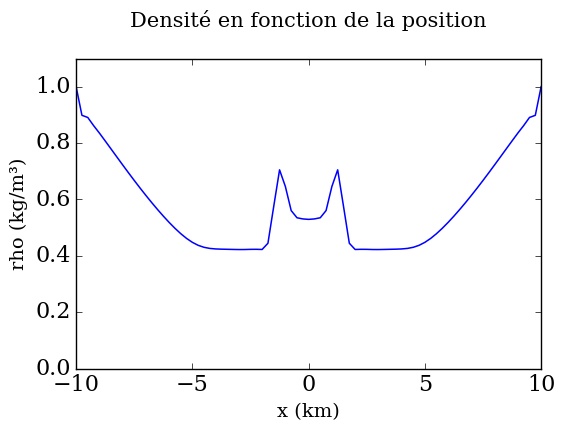

In [45]:
graphdensity(newplot(smooth4))

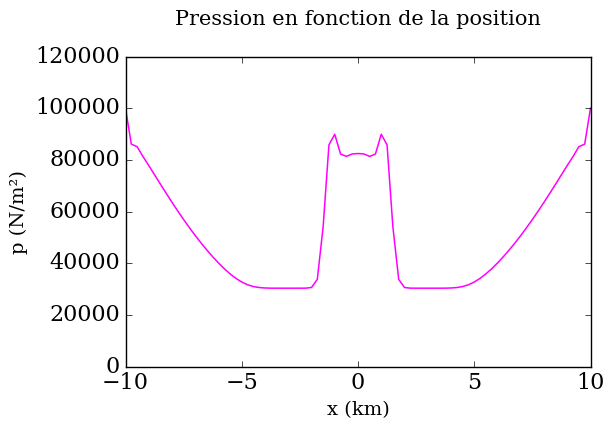

In [46]:
graphpress(newplot(smooth4))

## 7. Conclusion 

Nous avons pu voir, connaissant la solution analytique liée au phénomène étudié, que l'approche proposée par la méthode de Richtmeyer est bonne, et nous avons pu l'améliorer, moyennant une correction apportée à celle-ci (par le terme d'amortissement) . Notons que d'autres approches, comme celle du prédicteur-correcteur de MacCormack, peuvent donner des résultats plus ou moins proches de la solution exacte.